In [42]:
from ipywidgets import *
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
style = {'description_width': 'initial'}
layout = Layout(width = '400px')
models = [None] * 4 

## Реалізація МНКО

In [43]:
def RMNK(X, y, s=None, verbose=False, deep_verbose=False, create_dataframe=False):
    assert X.ndim == 2 and X.shape[1] > 0
    m = X.shape[1]
    if m > 1:
        if create_dataframe:
            w, H_inv, RSS, df = RMNK(X[:,:-1], y, s, verbose, deep_verbose, create_dataframe)
            if s is not None and m > s:
                return w, H_inv, RSS, df
        else:
            w, H_inv, RSS = RMNK(X[:,:-1], y, s, verbose, deep_verbose, create_dataframe)
            if s is not None and m > s:
                return w, H_inv, RSS
        # w is of shape = [m-1, 1]; H_inv is of shape = [m-1, m-1]    
        h = (X[:,:-1].T @ X[:,-1]).reshape(-1,1) # shape = [m-1, 1]
        eta = X[:,-1].T @ X[:,-1] # shape = [1, 1]
        alpha = H_inv @ h # shape = [m-1, 1]
        beta = eta - h.T @ alpha # shape = [1, 1]
        beta_inv = 1 / beta # shape = [1, 1]
        gamma = X[:,-1].T @ y # shape = [1, 1]
        nu = beta_inv * (gamma - h.T @ w) # shape = [1, 1]
        w = np.vstack((w - nu * alpha, nu))  # shape = [m, 1]
        H_next_inv = np.vstack((np.hstack((H_inv + beta_inv * alpha @ alpha.T, (- beta_inv * alpha).reshape(-1, 1))),
                               np.hstack((-beta_inv * alpha.T, beta_inv))))
        RSS_next = (RSS - nu.flatten() ** 2 * beta.flatten())[0]

    else: # 1
        H_inv = np.array([[0]])
        eta = beta = X[:,-1].T @ X[:,-1]
        beta_inv = 1 / beta
        alpha = h = np.array([0])
        gamma = X[:,-1].T @ y
        nu = np.array([beta_inv * gamma])
        w = np.array([nu])
        H_next_inv = np.array(beta_inv).reshape(1, 1)
        RSS_next = (y.T @ y - y.T @ X[:,-1].reshape(-1, 1) @ w)[0]
        if create_dataframe:
            df = pd.DataFrame(columns=['s', 'RSS', 'Cp', 'FPE'])
        
    if verbose:
        print('===============================================')
        print('\tStep {}'.format(m))
        print('===============================================')
        if deep_verbose:
            print('h_{}:\t\t{}'.format(m, h.reshape(-1,1)[:,0]))
            print('eta_{}:\t\t{}'.format(m, eta))
            print('alpha_{}:\t{}'.format(m, alpha.reshape(-1,1)[:,0]))
            print('beta_{}:\t\t{}'.format(m, beta))
            print('gamma_{}:\t{}'.format(m, gamma))
            print('nu_{}:\t\t{}'.format(m, nu))
            print('===============================================')
        print('> θ_{}: {}'.format(m, w[:, 0]))
        print('> H_{}_inv:\n{}'.format(m, H_next_inv))
        print('> RSS_{}: {}'.format(m, RSS_next))
    if create_dataframe:
        Cp = RSS_next + 2 * m
        n = y.shape[0]
        FPE = (n + m) / (n - m) * RSS_next
        df = df.append({'s': m, 'RSS': RSS_next, 'Cp': Cp, 'FPE': FPE},  ignore_index=True)
        return w, H_next_inv, RSS_next, df
    return w, H_next_inv, RSS_next

## 1. Модель Фергюльста

### Рівняння моделі
### $N'=μN(k-N) \enspace | \enspace N_0$ 

### Різницеве рівняння
### $\Delta t = 1$
### $N'(t)≈ N(t+1)-N(t) \enspace - \enspace різниця\:вперед$
### $N'(t)≈ N(t)-N(t-1) \enspace - \enspace різниця\:назад$
### $N'(t)≈ \frac{N(t+1)-N(t-1)}{2} \enspace - \enspace центральна\:різниця$
### $Розглядатимемо\: для\: різниці\: вперед:$
### $ \Rightarrow \left \{ \begin{array}{ll}N(t+1)-N(t)=μN(t)[k-N(t)] \\ N(0) = N_0\end{array} \right. $
### $ \iff \left \{ \begin{array}{ll}N(t+1)=(μk+1)N(t)-μN^2(t) \\ N(0) = N_0\end{array} \right. $
### $y_i = θ_1 x_{i1} +  θ_2 x_{i2} + ξ_i, \enspace \enspace θ_1 = μk+1; \enspace θ_2 = -μ; \enspace Eξ = 0_n; \enspace cov(ξ) = σ^2I_n$
### $ \left \{ \begin{array}{ll}
                  y_i = θ_1 x_{i1} +  θ_2 x_{i2} + ξ_i\\
                  θ_1 = μk+1\\
                  θ_2 = -μ\\
                  Eξ = 0_n;\enspace cov(ξ) = σ^2I_n
                \end{array}
              \right. $
### $ \Rightarrow \left \{ \begin{array}{ll}
                  μ = -θ_2 \\
                  k = (1 - θ_1) / θ_2
                \end{array}
              \right. $

Initial parameters:	μ = 0.0001
			k = 100
			N0 = 10

Noise generation: C = 3
Sample length: n = 50
Time starting from 0 to 500 with discretization frequency 10



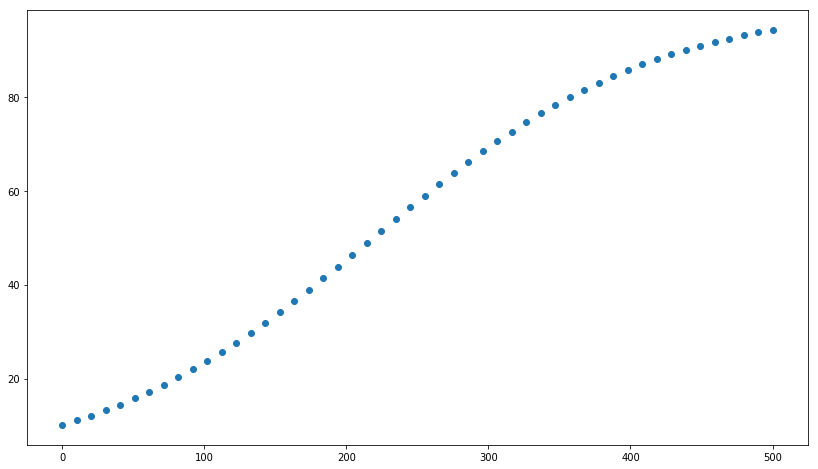

Intermediate parameters values: θ_1 = 1.01	θ_2 = -0.0001
Regression model: y = (1.01) * x1 + (-0.0001) * x2


,i,t,N(t),N^2(t),N(t+1)
0,1,0,10.000000,100.000000,10.090
1,2,10,10.956582,120.046684,11.054
2,3,20,11.992475,143.819461,12.098
3,4,30,13.111886,171.921546,13.226
4,5,40,14.318785,205.027597,14.441
5,6,51,15.616808,243.884680,15.749
6,7,61,17.009139,289.310822,17.150
7,8,71,18.498393,342.190549,18.649
8,9,81,20.086481,403.466709,20.247
9,10,91,21.774481,474.128027,21.945


In [44]:
def Verhulst_model_equation(N, t, μ, k):
    return μ * N * (k - N)

class VerhulstModelConfig(): 
    k = 100
    μ = 0.0001
    N0 = 10
    t_start = 0
    t_end = 500
    num_samples = 50
    num_samples_grid = [10, 50, 100]
    C = 3
    C_grid = [0, 2, 5]
    verbose_grid_search = False

    def __init__(self):
        self.theta = self.init_to_inter_params()
        self.compile()
        
    def compile(self):
        self.h = int((self.t_end - self.t_start) / (self.num_samples - 1))
        self.t = np.linspace(self.t_start, self.t_end, num=self.num_samples)
        self.N = odeint(Verhulst_model_equation, self.N0, self.t, (self.μ, self.k))
        self.create_data_sample()
        
    def recompile(self, C, num_samples):
        self.C = C
        self.num_samples = num_samples
        self.compile()
        
    def show(self):
        print('Initial parameters:\tμ = {}\n\t\t\tk = {}\n\t\t\tN0 = {}\n'.format(self.μ, self.k, self.N0))
        print('Noise generation: C = {}'.format(self.C))
        print('Sample length: n = {}'.format(self.num_samples))
        print('Time starting from {} to {} with discretization frequency {}\n'.format(self.t_start,
                                                                                     self.t_end,
                                                                                     self.h))
        
    def init_to_inter_params(self):
        w1 = self.μ * self.k + 1
        w2 = -self.μ
        return np.array([w1, w2])

    def inter_to_init_params(self, w1, w2):
        μ = - w2
        k = (1 - w1) / w2
        return μ, k
    
    def create_data_sample(self):
        self.df = pd.DataFrame()
        self.df['i'] = range(1, self.num_samples+1)
        self.df['t'] = list(map(int, self.t))
        self.df['N(t)'] = self.N.flatten()
        self.df['N^2(t)'] = np.square(self.N.flatten())
        self.df['N(t+1)'] = np.array(self.df[['N(t)','N^2(t)']]) @ self.theta
        self.df['N(t+1)'] = np.round(self.df['N(t+1)'], self.C)
        self.X = np.array(self.df[['N(t)', 'N^2(t)']])
        self.y = np.array(self.df['N(t+1)'])
    
    
config = VerhulstModelConfig()
config.show()

plt.scatter(config.t, config.y)
plt.show()
print('Intermediate parameters values: θ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('Regression model: y = ({}) * x1 + ({}) * x2'.format(*config.theta))
config.df.head(10)

Recurrent Least Squares Method
	Step 1
h_1:		[0]
eta_1:		192021.11695382808
alpha_1:	[0]
beta_1:		192021.11695382808
gamma_1:	192454.57239914758
nu_1:		[1.00225733]
> θ_1: [1.00225733]
> H_1_inv:
[[5.20776056e-06]]
> RSS_1: 0.5984206103312317
	Step 2
h_2:		[14865979.31260227]
eta_2:		1210738873.994198
alpha_2:	[77.41846078]
beta_2:		[[59837637.56477976]]
gamma_2:	14893552.797599493
nu_2:		[[-0.0001]]
> θ_2: [ 1.00999944e+00 -1.00003420e-04]
> H_2_inv:
[[ 1.05372445e-04 -1.29380878e-06]
 [-1.29380878e-06  1.67118897e-08]]
> RSS_2: 3.305702054645643e-06

INTERMEDIATE PARAMETERS
True values:	θ_1 = 1.01	θ_2 = -0.0001
Estimates:	θ_1* = 1.0099994430189032	θ_2* = -0.00010000341994463542

INITIAL PARAMETERS
True values:	μ = 0.0001	k = 100
Estimates:	μ* = 0.00010000341994463542	k* = 99.99101055183083


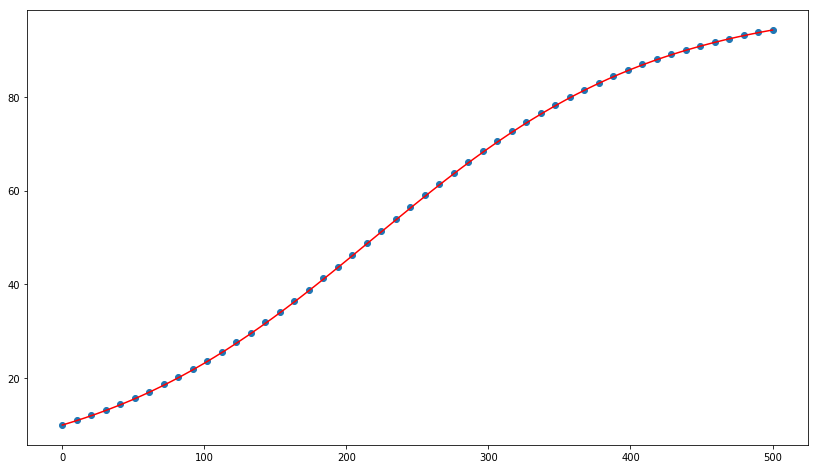

In [45]:
print('Recurrent Least Squares Method')
theta_pred = RMNK(config.X, config.y, verbose=True, deep_verbose=True)[0][:,0]
μ_pred, k_pred = config.inter_to_init_params(*theta_pred)
print('=============================================')
print('\nINTERMEDIATE PARAMETERS')
print('True values:\tθ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('Estimates:\tθ_1* = {}\tθ_2* = {}'.format(*theta_pred))
print('\nINITIAL PARAMETERS')
print('True values:\tμ = {}\tk = {}'.format(config.μ, config.k))
print('Estimates:\tμ* = {}\tk* = {}'.format(μ_pred, k_pred))
plt.scatter(config.t, config.y)
t_for_plot = np.linspace(config.t_start, config.t_end, num=config.num_samples * 10)
plt.plot(t_for_plot, odeint(Verhulst_model_equation, config.N0, t_for_plot, (μ_pred, k_pred)), 'r')
plt.show()

In [46]:
intermediate_estimates_df = pd.DataFrame(columns=['C', 'num_samples', 'θ_1*', 'θ_2*'])
initial_estimates_df = pd.DataFrame(columns=['C', 'num_samples', 'μ*', 'k*'])
for C in config.C_grid:
    for num_samples in config.num_samples_grid: 
        config.recompile(C, num_samples)
        intermediate_estimates_df
        theta_pred = RMNK(config.X, config.y, verbose=False)[0][:,0]
        μ_pred, k_pred = config.inter_to_init_params(*theta_pred)
        intermediate_estimates_df = \
        intermediate_estimates_df.append({'C': config.C, 'num_samples': config.num_samples,
                                          'θ_1*': theta_pred[0], 'θ_2*': theta_pred[1]},
                                         ignore_index=True)
        initial_estimates_df = \
        initial_estimates_df.append({'C': config.C, 'num_samples': config.num_samples,
                                     'μ*': μ_pred, 'k*': k_pred},
                                     ignore_index=True)
        if config.verbose_grid_search:
            print('=============================================================')
            print('C: {}\t num_samples: {}'.format(config.C, config.num_samples))
            print('\nINTERMEDIATE PARAMETERS')
            print('Estimates:\tθ_1* = {: 12.8}\tθ_2* = {:12.8}'.format(*theta_pred))
            print('\nINITIAL PARAMETERS')
            print('Estimates:\tμ* = {: 12.8}\tk* = {: 12.8}'.format(μ_pred, k_pred))
            
print('True inter. params values:\tθ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('True init.  params values:\tμ = {}\tk = {}'.format(config.μ, float(config.k)))
pd.concat([intermediate_estimates_df, initial_estimates_df[['μ*', 'k*']]], axis=1)

True inter. params values:	θ_1 = 1.01	θ_2 = -0.0001
True init.  params values:	μ = 0.0001	k = 100.0


,C,num_samples,θ_1*,θ_2*,μ*,k*
0,0.0,10.0,0.998957,0.000044,-0.000044,23.826999
1,0.0,50.0,1.010265,-0.000106,0.000106,96.768521
2,0.0,100.0,1.009688,-0.000097,0.000097,100.083587
3,2.0,10.0,1.009857,-0.000098,0.000098,100.559471
4,2.0,50.0,1.009994,-0.000100,0.000100,100.105598
5,2.0,100.0,1.009956,-0.000099,0.000099,100.113571
6,5.0,10.0,1.010000,-0.000100,0.000100,100.000233
7,5.0,50.0,1.010000,-0.000100,0.000100,100.000141
8,5.0,100.0,1.010000,-0.000100,0.000100,100.000091


---

## 2. Рівняння вимушених коливань

### Модель рівняння
### $x''+2δ x'+ω_0^2 x=0$

### Різницеве рівняння
### $\Delta t = 1$
### $x'(t)≈ x(t+1)-x(t) \enspace - \enspace різниця\:вперед$
### $x'(t)≈ x(t)-x(t-1) \enspace - \enspace різниця\:назад$
### $x'(t)≈ \frac{x(t+1)-x(t-1)}{2} \enspace - \enspace центральна\:різниця$
### $x''(t)≈ x(t+1)-2x(t)+x(t-1)$
### $Розглянемо\: для\: апроксимації\: різницею\: вперед:$
### $ \Rightarrow \left \{ \begin{array}{ll}x(t+1)-2x(t)+x(t-1)+2δ[x(t+1)-x(t)]+ω_0^2 x(t)=0 \\ x(0) = x_0\\ x(1) = x(0) + x'(0) = x_0 + x'_0 \end{array} \right. $
### $ \iff \left \{ \begin{array}{ll}x(t+2)=\frac{2+2δ-ω_0^2}{1+2δ}x(t+1)-\frac{1}{1+2δ}x(t) \\ x(0) = x_0\\ x(1) = x_0 + x'_0 \end{array} \right. $
### $ \left \{ \begin{array}{ll}
                  y_i = θ_1 x_{i1} +  θ_2 x_{i2} + ξ_i\\
                  θ_1 = \frac{2+2δ-ω_0^2}{1+2δ}\\
                  θ_2 = -\frac{1}{1+2δ}\\
                  Eξ = 0_n;\enspace cov(ξ) = σ^2I_n
                \end{array}
              \right. $
              

Initial parameters:	δ = 0.005
			ω0^2 = 0.01              
			x0 = 5
			x00 = 2

Noise generation: C = 2
Sample length: n = 80
Time starting from 0 to 500 with discretization frequency 6



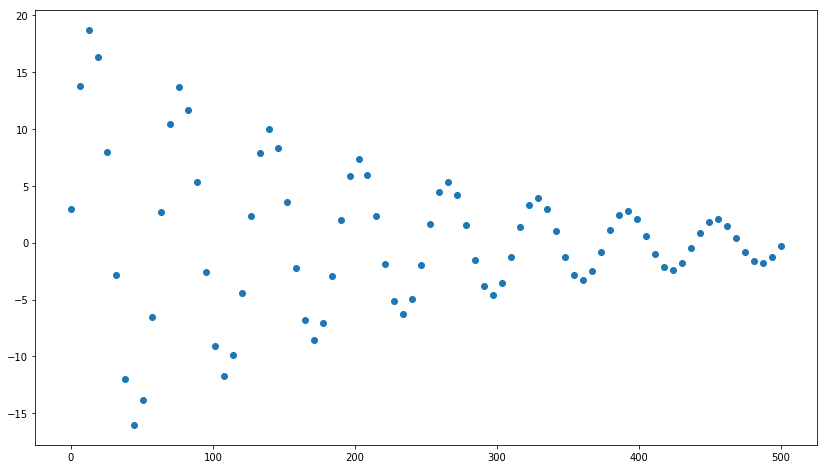

Intermediate parameters values: θ_1 = 1.98019801980198	θ_2 = -0.9900990099009901
Regression model: y = (1.98019801980198) * x1 + (-0.9900990099009901) * x2


,i,t,x(t),x(t+1),x(t+2)
0,1,0,5.000000,7.000000,2.97
1,2,6,15.514879,17.135487,13.76
2,3,12,19.560926,20.217068,18.72
3,4,18,16.016072,15.520598,16.35
4,5,25,6.676531,5.286058,7.99
5,6,31,-4.596447,-6.305073,-2.86
6,7,37,-13.452646,-14.818532,-11.97
7,8,44,-16.715857,-17.247299,-16.02
8,9,50,-13.504159,-13.052839,-13.82
9,10,56,-5.420258,-4.215867,-6.56


In [47]:
def Oscillation_model_equation(x, t, δ, ω0_sqr):
    #x_0' = x_1 = x'
    #x_1' = x'' = - 2 * δ * x[1] - (ω0 ** 2) * x[0]
    return [x[1],  - 2 * δ * x[1] - ω0_sqr * x[0]]        

class OscillationModelConfig(): 
    δ = 0.005
    ω0_sqr = 0.01
    x0 = 5
    x00 = 2
    t_start = 0
    t_end = 500
    num_samples = 80
    num_samples_grid = [30, 80, 150]
    C = 2
    C_grid = [0, 2, 5]
    verbose_grid_search = False

    def __init__(self):
        self.theta = self.init_to_inter_params()
        self.compile()
        
    def compile(self):
        self.h = int((self.t_end - self.t_start) / (self.num_samples - 1))
        self.t = np.linspace(self.t_start, self.t_end, num=self.num_samples)
        self.x = odeint(Oscillation_model_equation, np.array([self.x0, self.x00]), self.t, (self.δ, self.ω0_sqr))
        self.x1 = self.x0 + self.x00
        self.x11 = self.x00
        self.x_1 = odeint(Oscillation_model_equation, np.array([self.x1, self.x11]), self.t+1, (self.δ, self.ω0_sqr))
        self.create_data_sample()
        
    def recompile(self, C, num_samples):
        self.C = C
        self.num_samples = num_samples
        self.compile()
        
    def show(self):
        print('Initial parameters:\tδ = {}\n\t\t\tω0^2 = {}\
              \n\t\t\tx0 = {}\n\t\t\tx00 = {}\n'.format(self.δ, self.ω0_sqr, self.x0, self.x00))
        print('Noise generation: C = {}'.format(self.C))
        print('Sample length: n = {}'.format(self.num_samples))
        print('Time starting from {} to {} with discretization frequency {}\n'.format(self.t_start,
                                                                                     self.t_end,
                                                                                     self.h))
        
    def init_to_inter_params(self):
        divider = 1 + 2 * self.δ
        w1 = (2 + 2 * self.δ - self.ω0_sqr) / divider
        w2 = - 1 / divider
        return np.array([w1, w2])

    def inter_to_init_params(self, w1, w2):
        δ = - (1 / w2 + 1) / 2
        ω0_sqr = 1 - 1 / w2 + w1 / w2
        return δ, ω0_sqr
    
    def create_data_sample(self):
        self.df = pd.DataFrame()
        self.df['i'] = range(1, self.num_samples+1)
        self.df['t'] = list(map(int, self.t))
        self.df['x(t)'] = self.x[:,0].flatten()
        self.df['x(t+1)'] = self.x_1[:,0].flatten()
        self.df['x(t+2)'] = np.array(self.df[['x(t)','x(t+1)']]) @ self.theta
        self.df['x(t+2)'] = np.round(self.df['x(t+2)'], self.C)
        self.X = np.array(self.df[['x(t)', 'x(t+1)']])
        self.y = np.array(self.df['x(t+2)'])
        
        
config = OscillationModelConfig()
config.show()

plt.scatter(config.t, config.y)
plt.show()
print('Intermediate parameters values: θ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('Regression model: y = ({}) * x1 + ({}) * x2'.format(*config.theta))
config.df.head(10)

Recurrent Least Squares Method
	Step 1
h_1:		[0]
eta_1:		3496.0743024036183
alpha_1:	[0]
beta_1:		3496.0743024036183
gamma_1:	3349.3120437748094
nu_1:		[0.95802084]
> θ_1: [0.95802084]
> H_1_inv:
[[0.00028604]]
> RSS_1: 29.453858680092708
	Step 2
h_2:		[3609.56221018]
eta_2:		3756.7578218698554
alpha_2:	[1.03246153]
beta_2:		[[30.02371322]]
gamma_2:	3428.298727481169
nu_2:		[[-0.99045368]]
> θ_2: [ 1.98062616 -0.99045368]
> H_2_inv:
[[ 0.03579053 -0.0343882 ]
 [-0.0343882   0.03330701]]
> RSS_2: 0.0006414646978853966

INTERMEDIATE PARAMETERS
True values:	θ_1 = 1.98019801980198	θ_2 = -0.9900990099009901
Estimates:	θ_1* = 1.9806261560117373	θ_2* = -0.9904536768605925

INITIAL PARAMETERS
True values:	δ = 0.005			ω0^2 = 0.01
Estimates:	δ* = 0.004819166894137972	ω0^2* = 0.009922241775107699


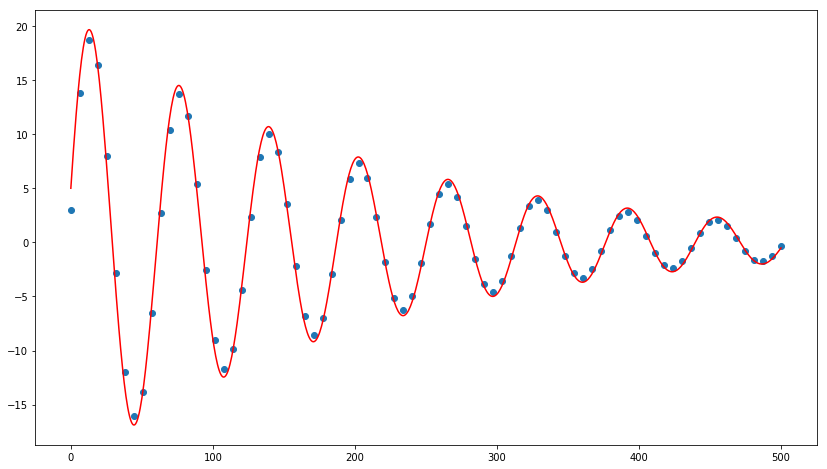

In [48]:
print('Recurrent Least Squares Method')
theta_pred = RMNK(config.X, config.y, verbose=True, deep_verbose=True)[0][:,0]
δ_pred, ω0_sqr_pred = config.inter_to_init_params(*theta_pred)
print('=============================================')
print('\nINTERMEDIATE PARAMETERS')
print('True values:\tθ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('Estimates:\tθ_1* = {}\tθ_2* = {}'.format(*theta_pred))
print('\nINITIAL PARAMETERS')
print('True values:\tδ = {}\t\t\tω0^2 = {}'.format(config.δ, config.ω0_sqr))
print('Estimates:\tδ* = {}\tω0^2* = {}'.format(δ_pred, ω0_sqr_pred))
plt.scatter(config.t, config.y)
t_for_plot = np.linspace(config.t_start, config.t_end, num=config.num_samples * 10)
plt.plot(t_for_plot, odeint(Oscillation_model_equation, np.array([config.x0, config.x00]),
                         t_for_plot, (δ_pred, ω0_sqr_pred))[:,0], 'r')
plt.show()

In [49]:
intermediate_estimates_df = pd.DataFrame(columns=['C', 'num_samples', 'θ_1*', 'θ_2*'])
initial_estimates_df = pd.DataFrame(columns=['C', 'num_samples', 'δ*', 'ω0_sqr*'])
for C in config.C_grid:
    for num_samples in config.num_samples_grid: 
        config.recompile(C, num_samples)
        intermediate_estimates_df
        theta_pred = RMNK(config.X, config.y, verbose=False)[0][:,0]
        δ_pred, ω0_sqr_pred = config.inter_to_init_params(*theta_pred)
        intermediate_estimates_df = \
        intermediate_estimates_df.append({'C': config.C, 'num_samples': config.num_samples,
                                          'θ_1*': theta_pred[0], 'θ_2*': theta_pred[1]},
                                         ignore_index=True)
        initial_estimates_df = \
        initial_estimates_df.append({'C': config.C, 'num_samples': config.num_samples,
                                     'δ*': δ_pred, 'ω0_sqr*': ω0_sqr_pred},
                                     ignore_index=True)
        if config.verbose_grid_search:
            print('=============================================================')
            print('C: {}\t num_samples: {}'.format(config.C, config.num_samples))
            print('\nINTERMEDIATE PARAMETERS')
            print('Estimates:\tθ_1* = {: 12.8}\tθ_2* = {:12.8}'.format(*theta_pred))
            print('\nINITIAL PARAMETERS')
            print('Estimates:\tδ* = {: 12.8}\tk* = {: 12.8}'.format(δ_pred, ω0_sqr_pred))
            
print('True inter. params values:\tθ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('True init.  params values:\tδ = {}\t\t\tω0^2 = {}'.format(config.δ, float(config.ω0_sqr)))
pd.concat([intermediate_estimates_df, initial_estimates_df[['δ*', 'ω0_sqr*']]], axis=1)

True inter. params values:	θ_1 = 1.98019801980198	θ_2 = -0.9900990099009901
True init.  params values:	δ = 0.005			ω0^2 = 0.01


,C,num_samples,θ_1*,θ_2*,δ*,ω0_sqr*
0,0.0,30.0,2.092809,-1.100300,-0.045579,0.006809
1,0.0,80.0,1.959643,-0.966105,0.017542,0.006689
2,0.0,150.0,1.985392,-0.991847,0.004110,0.006507
3,2.0,30.0,1.980402,-0.990257,0.004919,0.009952
4,2.0,80.0,1.980626,-0.990454,0.004819,0.009922
5,2.0,150.0,1.980007,-0.989910,0.005096,0.010005
6,5.0,30.0,1.980197,-0.990098,0.005001,0.010000
7,5.0,80.0,1.980199,-0.990100,0.005000,0.010000
8,5.0,150.0,1.980197,-0.990098,0.005000,0.010000


### $Розглянемо\: для\: апроксимації\: центральною\: різницею:$
### $ \Rightarrow \left \{ \begin{array}{ll}x(t+1)-2x(t)+x(t-1)+δ[x(t+1)-x(t-1)]+ω_0^2 x(t)=0 \\ x(0) = x_0\\ x(1) = x(0) + x'(0) = x_0 + x'_0 \end{array} \right. $
### $ \iff \left \{ \begin{array}{ll}x(t+2)=\frac{2-ω_0^2}{1+δ}x(t+1)-\frac{1-δ}{1+δ}x(t) \\ x(0) = x_0\\ x(1) = x_0 + x'_0 \end{array} \right. $
### $ \left \{ \begin{array}{ll}
                  y_i = θ_1 x_{i1} +  θ_2 x_{i2} + ξ_i\\
                  θ_1 = \frac{2-ω_0^2}{1+δ}\\
                  θ_2 = -\frac{1-δ}{1+δ}\\
                  Eξ = 0_n;\enspace cov(ξ) = σ^2I_n
                \end{array}
              \right. $

Initial parameters:	δ = 0.005
			ω0^2 = 0.01              
			x0 = 5
			x00 = 2

Noise generation: C = 2
Sample length: n = 80
Time starting from 0 to 500 with discretization frequency 6



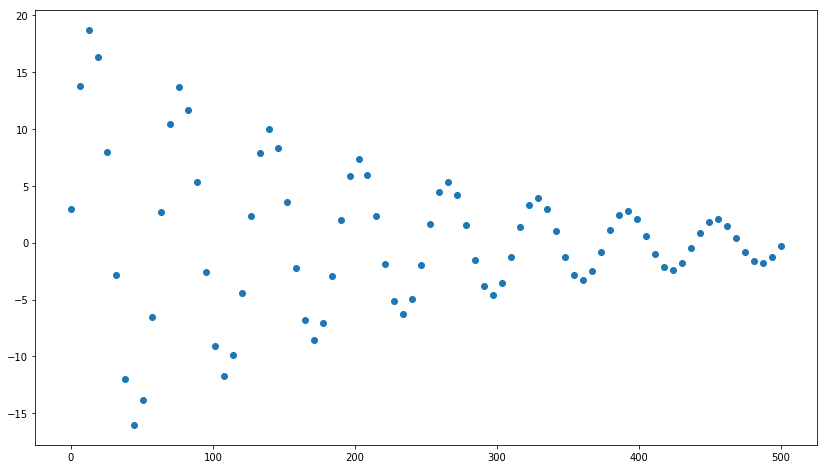

Intermediate parameters values: θ_1 = 1.9800995024875623	θ_2 = -0.9900497512437811
Regression model: y = (1.9800995024875623) * x1 + (-0.9900497512437811) * x2


,i,t,x(t),x(t+1),x(t+2)
0,1,0,5.000000,7.000000,2.97
1,2,6,15.514879,17.135487,13.76
2,3,12,19.560926,20.217068,18.72
3,4,18,16.016072,15.520598,16.35
4,5,25,6.676531,5.286058,7.99
5,6,31,-4.596447,-6.305073,-2.86
6,7,37,-13.452646,-14.818532,-11.97
7,8,44,-16.715857,-17.247299,-16.02
8,9,50,-13.504159,-13.052839,-13.82
9,10,56,-5.420258,-4.215867,-6.56


In [50]:
class OscillationModelConfig_center(OscillationModelConfig): 
    δ = 0.005
    ω0_sqr = 0.01
    x0 = 5
    x00 = 2
    t_start = 0
    t_end = 500
    num_samples = 80
    num_samples_grid = [30, 80, 150]
    C = 2
    C_grid = [0, 2, 5]
    verbose_grid_search = False

    def init_to_inter_params(self):
        divider = 1 + self.δ
        w1 = (2 - self.ω0_sqr) / divider
        w2 = - (1 - self.δ) / divider
        return np.array([w1, w2])

    def inter_to_init_params(self, w1, w2):
        δ = (1 + w2) / (1 - w2)
        ω0_sqr = (2 - 2 * w1 - 2 * w2) / (1 - w2)
        return δ, ω0_sqr
        
config = OscillationModelConfig_center()
config.show()

plt.scatter(config.t, config.y)
plt.show()
print('Intermediate parameters values: θ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('Regression model: y = ({}) * x1 + ({}) * x2'.format(*config.theta))
config.df.head(10)

Recurrent Least Squares Method
	Step 1
h_1:		[0]
eta_1:		3496.0743024036183
alpha_1:	[0]
beta_1:		3496.0743024036183
gamma_1:	3349.2782321079894
nu_1:		[0.95801117]
> θ_1: [0.95801117]
> H_1_inv:
[[0.00028604]]
> RSS_1: 29.447942916061493
	Step 2
h_2:		[3609.56221018]
eta_2:		3756.7578218698554
alpha_2:	[1.03246153]
beta_2:		[[30.02371322]]
gamma_2:	3428.2668093266866
nu_2:		[[-0.99035405]]
> θ_2: [ 1.98051363 -0.99035405]
> H_2_inv:
[[ 0.03579053 -0.0343882 ]
 [-0.0343882   0.03330701]]
> RSS_2: 0.0006504761413275162

INTERMEDIATE PARAMETERS
True values:	θ_1 = 1.9800995024875623	θ_2 = -0.9900497512437811
Estimates:	θ_1* = 1.9805136264573653	θ_2* = -0.9903540525860844

INITIAL PARAMETERS
True values:	δ = 0.005	ω0^2 = 0.01
Estimates:	δ* = 0.004846347513590607	ω0^2* = 0.00988811625342075


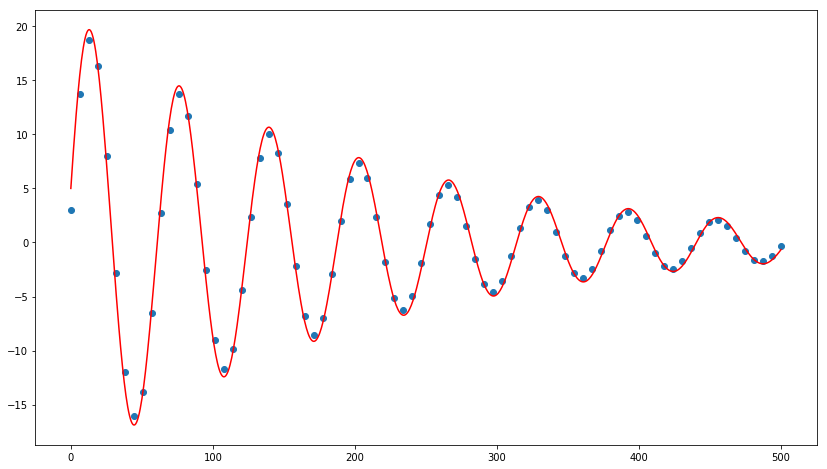

In [51]:
print('Recurrent Least Squares Method')
theta_pred = RMNK(config.X, config.y, verbose=True, deep_verbose=True)[0][:,0]
δ_pred, ω0_sqr_pred = config.inter_to_init_params(*theta_pred)
print('===============================================')
print('\nINTERMEDIATE PARAMETERS')
print('True values:\tθ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('Estimates:\tθ_1* = {}\tθ_2* = {}'.format(*theta_pred))
print('\nINITIAL PARAMETERS')
print('True values:\tδ = {}\tω0^2 = {}'.format(config.δ, config.ω0_sqr))
print('Estimates:\tδ* = {}\tω0^2* = {}'.format(δ_pred, ω0_sqr_pred))
plt.scatter(config.t, config.y)
t_for_plot = np.linspace(config.t_start, config.t_end, num=config.num_samples * 10)
plt.plot(t_for_plot, odeint(Oscillation_model_equation, np.array([config.x0, config.x00]),
                         t_for_plot, (δ_pred, ω0_sqr_pred))[:,0], 'r')
plt.show()

In [52]:
center_intermediate_estimates_df = pd.DataFrame(columns=['C', 'num_samples', 'θ_1*', 'θ_2*'])
center_initial_estimates_df = pd.DataFrame(columns=['C', 'num_samples', 'δ*', 'ω0_sqr*'])
for C in config.C_grid:
    for num_samples in config.num_samples_grid: 
        config.recompile(C, num_samples)
        intermediate_estimates_df
        theta_pred = RMNK(config.X, config.y, verbose=False)[0][:,0]
        δ_pred, ω0_sqr_pred = config.inter_to_init_params(*theta_pred)
        center_intermediate_estimates_df = \
        center_intermediate_estimates_df.append({'C': config.C, 'num_samples': config.num_samples,
                                          'θ_1*': theta_pred[0], 'θ_2*': theta_pred[1]},
                                         ignore_index=True)
        center_initial_estimates_df = \
        center_initial_estimates_df.append({'C': config.C, 'num_samples': config.num_samples,
                                     'δ*': δ_pred, 'ω0_sqr*': ω0_sqr_pred},
                                     ignore_index=True)
        if config.verbose_grid_search:
            print('=============================================================')
            print('C: {}\t num_samples: {}'.format(config.C, config.num_samples))
            print('\nINTERMEDIATE PARAMETERS')
            print('Estimates:\tθ_1* = {: 12.8}\tθ_2* = {:12.8}'.format(*theta_pred))
            print('\nINITIAL PARAMETERS')
            print('Estimates:\tδ* = {: 12.8}\tk* = {: 12.8}'.format(δ_pred, ω0_sqr_pred))
            
print('True inter. params values:\tθ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('True init.  params values:\tδ = {}\tω0^2 = {}'.format(config.δ, float(config.ω0_sqr)))
pd.concat([center_intermediate_estimates_df, center_initial_estimates_df[['δ*', 'ω0_sqr*']]], axis=1)

True inter. params values:	θ_1 = 1.9800995024875623	θ_2 = -0.9900497512437811
True init.  params values:	δ = 0.005	ω0^2 = 0.01


,C,num_samples,θ_1*,θ_2*,δ*,ω0_sqr*
0,0.0,30.0,2.092809,-1.100300,-0.047755,0.007134
1,0.0,80.0,1.959643,-0.966105,0.017240,0.006574
2,0.0,150.0,1.985392,-0.991847,0.004093,0.006481
3,2.0,30.0,1.980023,-0.989908,0.005071,0.009935
4,2.0,80.0,1.980514,-0.990354,0.004846,0.009888
5,2.0,150.0,1.979936,-0.989861,0.005095,0.009975
6,5.0,30.0,1.980099,-0.990050,0.005000,0.010000
7,5.0,80.0,1.980099,-0.990050,0.005000,0.010000
8,5.0,150.0,1.980100,-0.990050,0.005000,0.010000


In [53]:
center_df = pd.concat([center_intermediate_estimates_df, center_initial_estimates_df[['δ*', 'ω0_sqr*']]], axis=1)
center_df['difference'] = 'center'
forward_df = pd.concat([intermediate_estimates_df, initial_estimates_df[['δ*', 'ω0_sqr*']]], axis=1)
forward_df['difference'] = 'forward'
pd.concat([center_df, forward_df], axis=0).sort_values(by=['C', 'num_samples', 'difference'])

,C,num_samples,θ_1*,θ_2*,δ*,ω0_sqr*,difference
0,0.0,30.0,2.092809,-1.100300,-0.047755,0.007134,center
0,0.0,30.0,2.092809,-1.100300,-0.045579,0.006809,forward
1,0.0,80.0,1.959643,-0.966105,0.017240,0.006574,center
1,0.0,80.0,1.959643,-0.966105,0.017542,0.006689,forward
2,0.0,150.0,1.985392,-0.991847,0.004093,0.006481,center
2,0.0,150.0,1.985392,-0.991847,0.004110,0.006507,forward
3,2.0,30.0,1.980023,-0.989908,0.005071,0.009935,center
3,2.0,30.0,1.980402,-0.990257,0.004919,0.009952,forward
4,2.0,80.0,1.980514,-0.990354,0.004846,0.009888,center
4,2.0,80.0,1.980626,-0.990454,0.004819,0.009922,forward


## 3. Дослідження закономірностей задачі структурно параметричної ідентифікації 

In [54]:
class ModelConfig():
    m = 5
    n = 10
    n_grid = [10, 30, 100]
    theta = np.array([3, -2, 1, 0, 0])
    a = 0
    b = 10
    sigma = 0.01
    sigma_grid = [0.1, 0.5, 1]
    s = 5
    s_grid = [1, 2, 3, 4, 5]
    
    def __init__(self):
        self.compile()
        
    def generate_noise_and_output(self):
        self.ksi = np.random.normal(0, self.sigma, size=self.n)
        self.y = self.X @ self.theta + self.ksi
        
    def compile(self):
        self.X = np.random.uniform(self.a, self.b, size=(self.n, self.m))
        self.generate_noise_and_output()
        
    def recompile(self, n, sigma):
        self.n = n
        self.sigma = sigma
        self.compile()
        
    def show(self):
#         print('Regressors: m = {}'.format(self.m))
#         print('True parameters: θ = {}'.format(self.theta))
        print('Sample length: n = {}'.format(self.n))
        print('Noise generation: σ = {}'.format(self.sigma))
        print('X:\n{}'.format(self.X))
        print('y:\n{}'.format(self.y))
        
config = ModelConfig()

In [55]:
config.generate_noise_and_output()
config.show()

Sample length: n = 10
Noise generation: σ = 0.01
X:
[[7.18510472 9.57923819 4.24774226 9.35742405 6.19330933]
 [7.4715005  0.51795271 1.53987205 7.81704088 6.26318358]
 [2.32941886 4.81876047 9.92255995 3.09653907 4.88965107]
 [5.08143369 1.33324232 9.99005864 1.70078268 7.17281396]
 [0.27727291 4.62784747 5.40605528 8.28943171 5.73340838]
 [6.23066336 9.06304416 9.87715758 0.09327554 7.3315676 ]
 [8.18367747 7.71093384 1.9441399  5.92319424 2.28460914]
 [4.80373236 7.44312976 7.95306473 1.32835537 8.76917032]
 [0.6121952  4.39285532 8.21606205 8.97595376 0.49440412]
 [0.88404915 8.84708888 8.7464958  9.48840378 9.79065638]]
y:
[ 6.63311507 22.90001833  7.28274456 22.58555622 -3.03256125 10.45182207
 11.07694483  7.4770577   1.26332135 -6.2997683 ]


		CONFUGURATIONS & DATA
Sample length: n = 10
Noise generation: σ = 0.1
X:
[[8.49572873 6.57133561 8.14158447 0.3355411  2.99464937]
 [7.25837989 7.02944629 5.39008879 5.63319983 9.50558681]
 [9.99689711 1.05801477 2.14988299 8.83606571 6.60822296]
 [6.69701559 4.19876715 4.3424849  6.09082225 6.76931024]
 [8.93973619 2.70067689 8.46821229 7.95194887 7.28319132]
 [5.72265069 7.15789085 4.46480932 5.48264845 4.69971234]
 [4.16808327 1.83798987 8.21079317 5.51188594 2.46669604]
 [6.09450572 3.83238228 4.40123834 8.03315117 0.85771145]
 [0.83885733 9.02140985 1.47175546 8.14787794 1.53771683]
 [8.07517298 0.4426288  7.25201336 4.3701217  8.95708152]]
y:
[ 20.55553198  13.133096    29.94298621  16.10527805  29.97420358
   7.50126296  17.11809455  14.96999768 -14.08005588  30.40192494]

		RLSM ITERATIONS
	Step 1
> θ_1: [2.75351488]
> H_1_inv:
[[0.00198908]]
> RSS_1: 533.6124199154174
	Step 2
> θ_2: [ 3.66998714 -1.8225114 ]
> H_2_inv:
[[ 0.00376496 -0.00353155]
 [-0.00353155  0.0070229 ]]
>

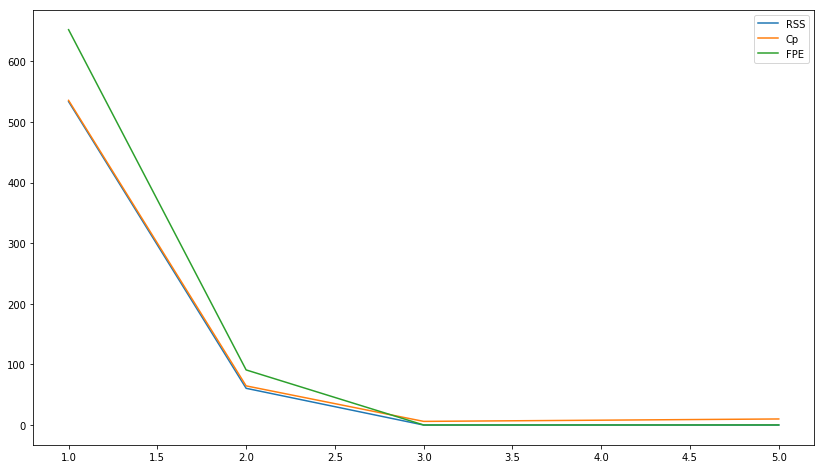

     s         RSS          Cp         FPE
0  1.0  533.612420  535.612420  652.192958
1  2.0   60.652628   64.652628   90.978942
2  3.0    0.078036    6.078036    0.144925
3  4.0    0.074479    8.074479    0.173784
4  5.0    0.073055   10.073055    0.219165

		CONFUGURATIONS & DATA
Sample length: n = 10
Noise generation: σ = 0.5
X:
[[2.55321149 5.4097362  0.13099336 4.3041341  4.43078092]
 [3.505616   3.33651908 3.26650077 6.25962753 7.78685359]
 [8.03946463 9.88862352 5.76510728 6.9458392  1.78891524]
 [4.54709497 7.59319145 6.23499719 6.22800801 7.42237662]
 [3.94549085 9.11432987 5.14829531 4.17437343 0.9696355 ]
 [7.45907131 6.06139585 5.21208115 3.57832    0.46033185]
 [0.56853462 7.05125701 2.36590698 7.58530345 5.68678659]
 [1.81023652 7.17240123 7.10059655 0.86792649 5.90854251]
 [5.55728373 9.37931709 2.11489219 6.7910699  5.63749121]
 [9.50363744 1.87716718 0.99932097 3.17113945 9.6567964 ]]
y:
[ -2.61036668   7.1009566   11.34381213   4.5740227   -1.27773611
  15.35773874 -1

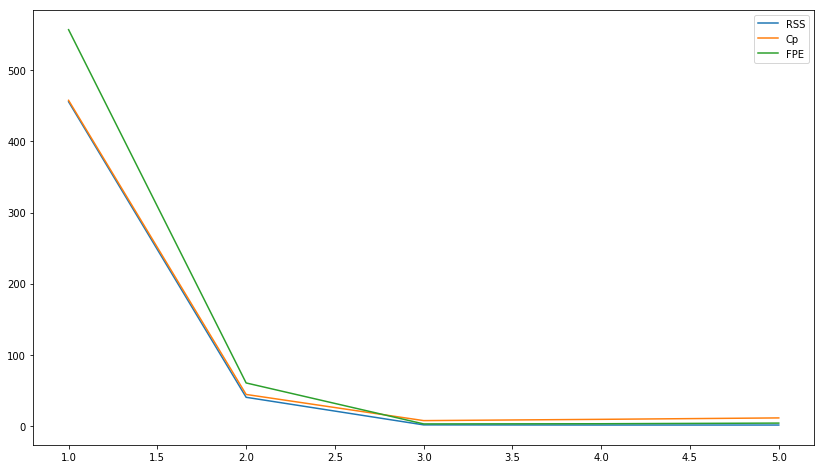

     s         RSS          Cp         FPE
0  1.0  455.728552  457.728552  557.001563
1  2.0   40.341792   44.341792   60.512688
2  3.0    1.574315    7.574315    2.923728
3  4.0    1.361426    9.361426    3.176661
4  5.0    1.359710   11.359710    4.079131

		CONFUGURATIONS & DATA
Sample length: n = 10
Noise generation: σ = 1
X:
[[9.32127526 2.91583211 5.78003733 0.83271557 6.58964026]
 [8.23012494 3.67181085 9.65913407 9.25859338 5.96762654]
 [2.473676   9.8705406  9.60378011 5.48589034 6.17591765]
 [1.07496857 3.55698678 4.95492952 0.48540673 3.00016459]
 [9.43075953 9.79423161 7.00755985 9.9199597  8.53037294]
 [0.80578447 6.60457335 2.71571624 3.32604851 0.5019605 ]
 [7.99305402 6.73130552 1.93684034 2.23826762 7.4728878 ]
 [1.71099166 3.56281437 8.9913413  0.96063844 5.77313582]
 [2.44077345 0.10393917 9.65348614 1.32514986 2.74236249]
 [5.12488814 7.03422361 9.72192475 2.44910831 7.62446025]]
y:
[28.24951294 28.43673959 -2.8217554   2.01422025 15.71510241 -7.70954066
 13.1460535

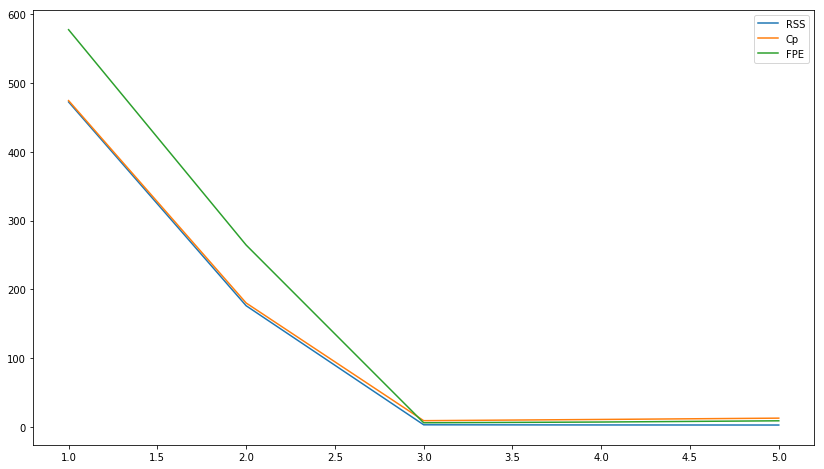

     s         RSS          Cp         FPE
0  1.0  472.495843  474.495843  577.494919
1  2.0  176.411535  180.411535  264.617303
2  3.0    3.412785    9.412785    6.338029
3  4.0    3.188346   11.188346    7.439474
4  5.0    3.074063   13.074063    9.222190

		CONFUGURATIONS & DATA
Sample length: n = 30
Noise generation: σ = 0.1
X:
[[0.52815153 2.49067342 7.44503832 4.831941   0.78549909]
 [9.2158767  0.60885654 2.36639601 0.82361114 2.08828427]
 [2.45300274 4.59380399 6.12231924 3.78900731 2.16714469]
 [0.43601217 2.84643863 7.80591579 3.77568365 5.69237186]
 [5.7233549  3.16810297 3.46489961 5.43326402 1.97446078]
 [5.05161088 9.48136803 0.88324497 6.42713973 2.50911787]
 [7.6180827  1.43988411 0.38533514 1.69299081 8.22752204]
 [9.39778313 8.32300718 4.77344629 3.75556831 5.80552682]
 [9.14454066 3.16690199 7.16958903 8.82041307 2.50578106]
 [6.89610094 5.1806053  5.53066795 7.59235449 7.88993861]
 [4.74948645 8.83213135 3.4474165  2.97142698 6.97436904]
 [6.16361999 4.51629476 2.49

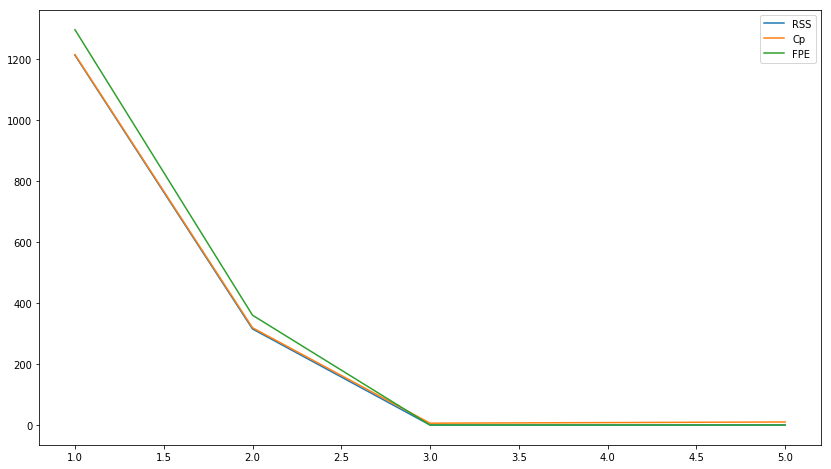

     s          RSS           Cp          FPE
0  1.0  1211.980877  1213.980877  1295.565765
1  2.0   315.061522   319.061522   360.070310
2  3.0     0.259911     6.259911     0.317669
3  4.0     0.233410     8.233410     0.305229
4  5.0     0.219431    10.219431     0.307204

		CONFUGURATIONS & DATA
Sample length: n = 30
Noise generation: σ = 0.5
X:
[[5.8605695  1.19457593 3.97343703 3.47094216 5.64792536]
 [7.67809925 4.1364781  8.81091244 5.49901779 0.43681056]
 [6.61162818 0.42333809 4.93489175 6.64980657 8.76731807]
 [8.65925813 8.16876538 8.72229521 8.20444563 3.22001457]
 [4.44418255 8.54590602 2.53281944 0.66399171 4.7298252 ]
 [6.5726788  8.50415042 1.18221868 0.0467472  1.57955985]
 [9.58820459 8.21080954 7.20942869 0.12381806 8.36818809]
 [2.69213121 3.71534078 0.68651094 3.72160759 9.23311426]
 [6.81906266 3.66386905 4.27174984 2.38394848 4.48546481]
 [9.32014548 9.85037828 2.80310704 9.30112562 8.28116586]
 [4.97287895 8.66410922 7.3369462  1.99071276 3.22467432]
 [0.224391

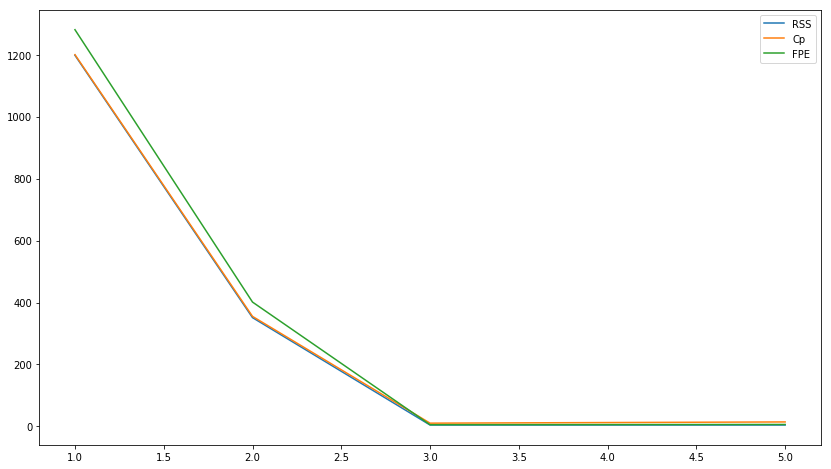

     s          RSS           Cp          FPE
0  1.0  1198.339524  1200.339524  1280.983629
1  2.0   351.359146   355.359146   401.553310
2  3.0     4.611249    10.611249     5.635971
3  4.0     4.605621    12.605621     6.022735
4  5.0     4.562657    14.562657     6.387720

		CONFUGURATIONS & DATA
Sample length: n = 30
Noise generation: σ = 1
X:
[[8.45842525 7.01267281 4.98784361 9.88367499 6.89883311]
 [3.12740823 9.080853   0.19753815 9.33179903 1.95708086]
 [0.02493155 5.78766127 0.10103612 4.97720033 7.38556103]
 [0.73284247 7.86661391 3.66961453 7.58629112 3.70274759]
 [4.83655188 5.87808301 2.43099083 1.730612   4.32224371]
 [4.17379193 4.25047734 1.47456846 4.45657529 0.96273431]
 [8.537014   2.78120636 2.7848213  3.44327182 9.11965517]
 [8.87377801 6.96593501 0.45814655 4.05290981 7.72934276]
 [0.76439557 5.55526243 3.32462738 8.02687633 4.50088733]
 [7.43289873 8.37857541 9.49620883 9.15754987 6.59401788]
 [1.93992558 0.42106175 9.41970896 9.17894999 6.6526994 ]
 [8.90219357

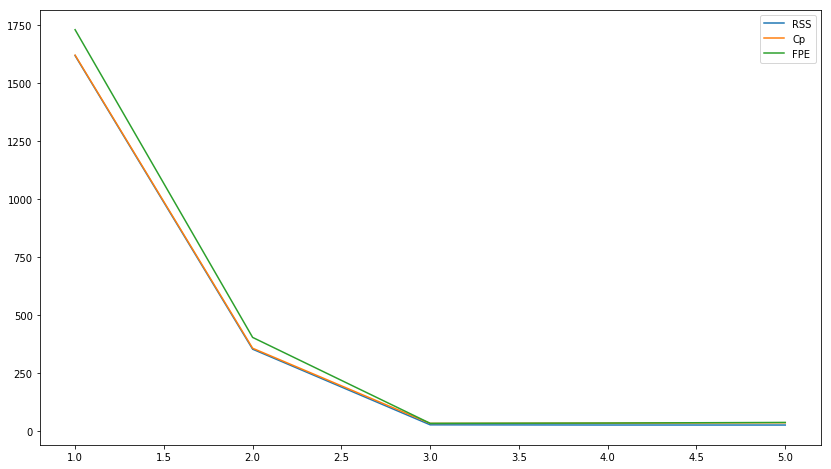

     s          RSS           Cp          FPE
0  1.0  1618.167371  1620.167371  1729.765121
1  2.0   354.333951   358.333951   404.953087
2  3.0    28.656626    34.656626    35.024765
3  4.0    27.799451    35.799451    36.353128
4  5.0    27.731159    37.731159    38.823623

		CONFUGURATIONS & DATA
Sample length: n = 100
Noise generation: σ = 0.1
X:
[[9.45535995e+00 4.77680889e+00 1.84458174e+00 3.75484932e+00
  2.12321445e+00]
 [3.08986093e+00 1.67924358e-01 6.18435322e+00 9.17904739e+00
  6.24441411e+00]
 [7.78976380e+00 2.50327393e-02 1.12023475e+00 2.91794886e+00
  7.68152190e+00]
 [4.94074916e+00 1.18793042e+00 9.67989449e+00 7.38788463e+00
  1.73671834e+00]
 [3.08424902e+00 7.52393114e+00 6.98189662e+00 6.53825557e+00
  9.38874506e+00]
 [9.02903778e+00 9.31772628e+00 8.71028151e-02 8.17359258e+00
  4.77322279e+00]
 [2.87755980e+00 4.28650677e+00 5.90361254e+00 1.71606095e+00
  7.18020268e+00]
 [3.20575439e-01 6.46778182e+00 7.13108431e+00 4.15447753e-01
  5.73217429e+00]
 [1.242

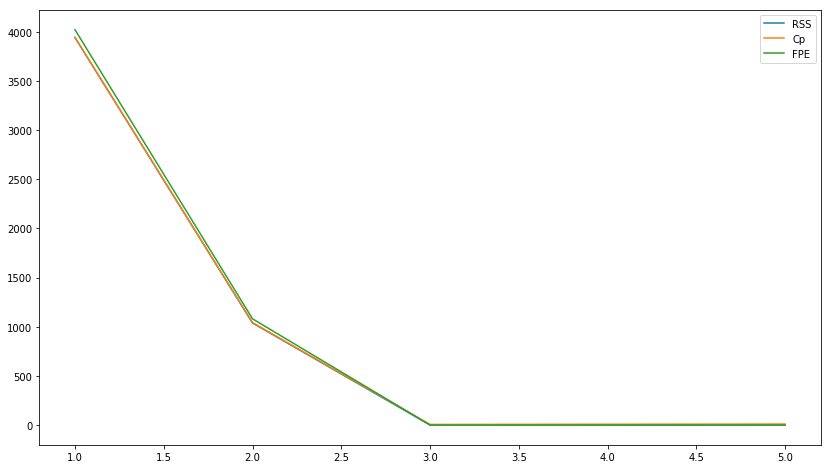

     s          RSS           Cp          FPE
0  1.0  3942.308706  3944.308706  4021.951306
1  2.0  1039.104683  1043.104683  1081.517119
2  3.0     1.032009     7.032009     1.095844
3  4.0     0.995344     8.995344     1.078289
4  5.0     0.990302    10.990302     1.094545

		CONFUGURATIONS & DATA
Sample length: n = 100
Noise generation: σ = 0.5
X:
[[4.77464327 8.65997349 5.39963203 3.54945959 8.35522307]
 [1.65412799 1.96618358 3.78091443 5.81478354 7.99832501]
 [7.52834454 2.3715636  9.91268966 7.38953598 2.49776756]
 [1.87627409 8.45372566 1.17318857 0.07748644 6.24948564]
 [7.66732929 0.18191092 5.22294794 4.55949413 6.37228332]
 [3.14661654 5.21473983 7.61550216 1.46544241 6.6616005 ]
 [4.13391438 1.11940049 9.21994167 7.85795177 6.60053948]
 [2.47687532 2.25251644 4.27362917 9.05507689 0.85804646]
 [1.77527342 7.03527535 3.65148131 8.60197276 9.15438041]
 [2.929519   7.57868008 7.02636499 1.61366731 6.73339817]
 [7.68357788 8.31184558 7.99953997 0.20506555 3.29308497]
 [2.07232

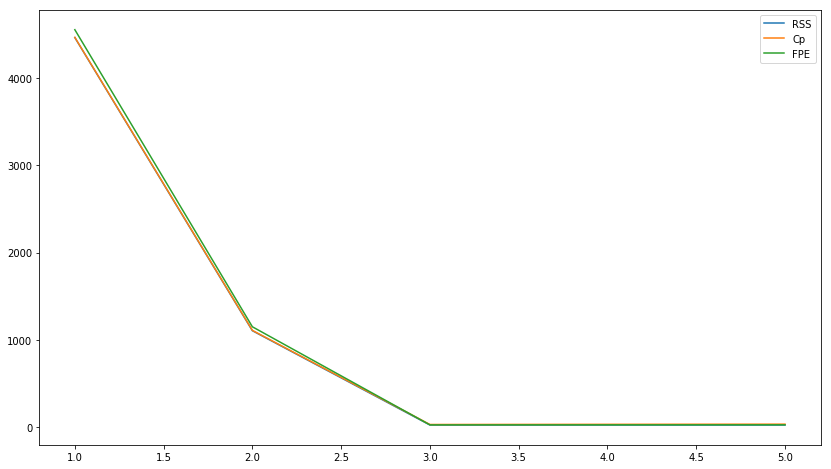

     s          RSS           Cp          FPE
0  1.0  4466.686314  4468.686314  4556.922401
1  2.0  1105.361782  1109.361782  1150.478589
2  3.0    24.188801    30.188801    25.685016
3  4.0    24.129658    32.129658    26.140462
4  5.0    23.968217    33.968217    26.491187

		CONFUGURATIONS & DATA
Sample length: n = 100
Noise generation: σ = 1
X:
[[1.14869758 1.15052571 6.30265652 7.09343632 5.39867841]
 [2.42175515 3.4266768  7.45397807 9.90443944 3.94115962]
 [8.8217932  3.01687808 0.11750567 6.89380348 0.08857899]
 [3.43657635 9.36128475 3.08532257 6.64292074 3.2315667 ]
 [9.08262921 7.04535054 6.17422514 4.45015694 9.64448671]
 [5.34401582 9.04270483 3.12910603 9.43404053 2.30518168]
 [9.20296727 7.54682961 0.05304348 4.96700534 3.79030711]
 [9.93134062 1.19720931 4.53579129 5.87250632 5.68981655]
 [1.51349957 6.09168511 0.38045628 2.63515933 3.37343966]
 [2.66853556 4.80368422 3.00559735 0.75148289 1.54272043]
 [3.81498619 0.40542627 4.65898977 9.18164852 3.97099525]
 [9.1699060

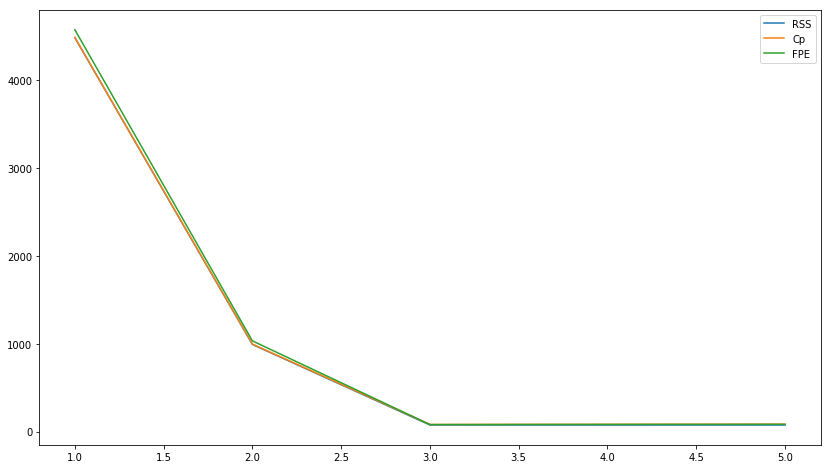

     s          RSS           Cp          FPE
0  1.0  4482.835062  4484.835062  4573.397387
1  2.0   992.943324   996.943324  1033.471623
2  3.0    76.403750    82.403750    81.129756
3  4.0    76.393660    84.393660    82.759798
4  5.0    75.972650    85.972650    83.969771



In [56]:
for n in config.n_grid: 
    for sigma in config.sigma_grid:
        config.recompile(n, sigma)
        print('==========================================================================================================')
        print('\t\tCONFUGURATIONS & DATA')
        config.show()
        print('\n\t\tRLSM ITERATIONS')
        theta_pred, _, _, df = RMNK(config.X, config.y, s=config.s, verbose=True, create_dataframe=True)
        print('===============================================')
        print('\n\t\tRESULTS')
        print('\nPARAMETERS')
        print('True values:\tθ: {}'.format(config.theta))
        print('Estimates:\tθ*: {}'.format(theta_pred[:,0]))
        plt.plot(df['s'], df['RSS'], label='RSS')
        plt.plot(df['s'], df['Cp'], label='Cp')
        plt.plot(df['s'], df['FPE'], label='FPE')
        plt.legend()
        plt.show()
        print(df)
        print()